In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import re
from typing import Dict, List, Tuple, Optional
import nibabel as nib
from scipy import ndimage
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette("husl")

print("�� Libraries imported successfully!")

## 1. Data Loading and Setup

# Paths
protein_data_folder = Path(r"D:\ADNI\AD_CN\proteomics\Biomarkers Consortium Plasma Proteomics MRM")
mri_base_folder = Path(r"D:\ADNI\AD_CN\proteomics\Biomarkers Consortium Plasma Proteomics MRM\MRI\MRI_1 (1)\ADNI")

# Load the splits from protein classification
train_path = protein_data_folder / "proteomic_w_labels_TRAIN.csv"
test_path = protein_data_folder / "proteomic_w_labels_TEST.csv"  git 
cv_folds_path = protein_data_folder / "cv_fold_indices.csv"

print(f"🔍 Loading data splits from protein classification...")
print(f"   • Training set: {train_path}")
print(f"   • Test set: {test_path}")
print(f"   • CV folds: {cv_folds_path}")

# Load the data
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
cv_folds_df = pd.read_csv(cv_folds_path)

print(f"📊 Data loaded:")
print(f"   • Training samples: {len(train_df)}")
print(f"   • Test samples: {len(test_df)}")
print(f"   • CV fold assignments: {len(cv_folds_df)}")

# Display sample data
print(f"\n📋 Training set sample:")
print(train_df[['RID', 'VISCODE', 'research_group']].head())

print(f"\n📋 CV folds sample:")
print(cv_folds_df.head())


�� Libraries imported successfully!
🔍 Loading data splits from protein classification...
   • Training set: D:\ADNI\AD_CN\proteomics\Biomarkers Consortium Plasma Proteomics MRM\proteomic_w_labels_TRAIN.csv
   • Test set: D:\ADNI\AD_CN\proteomics\Biomarkers Consortium Plasma Proteomics MRM\proteomic_w_labels_TEST.csv
   • CV folds: D:\ADNI\AD_CN\proteomics\Biomarkers Consortium Plasma Proteomics MRM\cv_fold_indices.csv
📊 Data loaded:
   • Training samples: 91
   • Test samples: 23
   • CV fold assignments: 570

📋 Training set sample:
    RID VISCODE research_group
0     5      bl             CN
1    66      bl             CN
2   726      bl             CN
3    22      bl             CN
4  1063      bl             CN

📋 CV folds sample:
   original_index  RID  fold split_type
0               0    3     1      train
1               1    5     1      train
2               2    8     1      train
3               3   10     1      train
4               5   16     1      train


In [8]:
import os
folder_count = len([d for d in os.listdir(r"D:\ADNI\AD_CN\proteomics\Biomarkers Consortium Plasma Proteomics MRM\MRI\MRI_1 (1)\ADNI") 
                    if os.path.isdir(os.path.join(r"D:\ADNI\AD_CN\proteomics\Biomarkers Consortium Plasma Proteomics MRM\MRI\MRI_1 (1)\ADNI", d))])

print(f"📁 Found {folder_count} folders")

📁 Found 39 folders


In [4]:

## 2. RID to Subject ID Mapping

def extract_rid_from_subject_id(subject_id: str) -> int:
    """Extract RID from subject ID (e.g., '002_S_0413' -> 413)"""
    # Extract the last part after underscore
    rid_str = subject_id.split('_')[-1]
    return int(rid_str)

def find_subject_id_for_rid(rid: int, mri_base_folder: Path) -> Optional[str]:
    """Find subject ID folder for a given RID"""
    if not mri_base_folder.exists():
        print(f"❌ MRI base folder not found: {mri_base_folder}")
        return None
    
    # List all subject folders
    subject_folders = [f for f in mri_base_folder.iterdir() if f.is_dir()]
    
    for subject_folder in subject_folders:
        subject_id = subject_folder.name
        try:
            folder_rid = extract_rid_from_subject_id(subject_id)
            if folder_rid == rid:
                return subject_id
        except (ValueError, IndexError):
            continue
    
    return None

def create_rid_to_subject_mapping(mri_base_folder: Path, max_samples: int = 50) -> Dict[int, str]:
    """Create mapping from RID to subject ID for available MRI data"""
    print(f"🔍 Creating RID to subject ID mapping...")
    
    if not mri_base_folder.exists():
        print(f"❌ MRI base folder not found: {mri_base_folder}")
        return {}
    
    # List all subject folders
    subject_folders = [f for f in mri_base_folder.iterdir() if f.is_dir()]
    print(f"   • Found {len(subject_folders)} subject folders")
    
    # Create mapping
    rid_to_subject = {}
    sample_count = 0
    
    for subject_folder in subject_folders:
        if sample_count >= max_samples:
            break
            
        subject_id = subject_folder.name
        try:
            rid = extract_rid_from_subject_id(subject_id)
            rid_to_subject[rid] = subject_id
            sample_count += 1
            
            if sample_count <= 10:  # Show first 10
                print(f"   • RID {rid:3d} → {subject_id}")
                
        except (ValueError, IndexError):
            continue
    
    print(f"   • Mapped {len(rid_to_subject)} RIDs to subject IDs")
    return rid_to_subject

# Create the mapping
rid_to_subject = create_rid_to_subject_mapping(mri_base_folder, max_samples=100)

# Check overlap with our protein data
train_rids = set(train_df['RID'].unique())
test_rids = set(test_df['RID'].unique())
available_rids = set(rid_to_subject.keys())

print(f"\n📊 RID Coverage Analysis:")
print(f"   • Training RIDs: {len(train_rids)}")
print(f"   • Test RIDs: {len(test_rids)}")
print(f"   • Available MRI RIDs: {len(available_rids)}")
print(f"   • Training RIDs with MRI: {len(train_rids & available_rids)}")
print(f"   • Test RIDs with MRI: {len(test_rids & available_rids)}")

# Show some examples
print(f"\n📋 Example RID mappings:")
for rid in list(train_rids)[:5]:
    if rid in rid_to_subject:
        print(f"   • RID {rid} → {rid_to_subject[rid]} (TRAIN)")
    else:
        print(f"   • RID {rid} → No MRI found (TRAIN)")


🔍 Creating RID to subject ID mapping...
   • Found 39 subject folders
   • RID  31 → 023_S_0031
   • RID  29 → 067_S_0029
   • RID  61 → 023_S_0061
   • RID 139 → 023_S_0139
   • RID 260 → 127_S_0260
   • RID  86 → 136_S_0086
   • RID 441 → 131_S_0441
   • RID 403 → 027_S_0403
   • RID 413 → 002_S_0413
   • RID 433 → 133_S_0433
   • Mapped 39 RIDs to subject IDs

📊 RID Coverage Analysis:
   • Training RIDs: 122
   • Test RIDs: 32
   • Available MRI RIDs: 39
   • Training RIDs with MRI: 26
   • Test RIDs with MRI: 15

📋 Example RID mappings:
   • RID 3 → No MRI found (TRAIN)
   • RID 5 → No MRI found (TRAIN)
   • RID 519 → No MRI found (TRAIN)
   • RID 8 → No MRI found (TRAIN)
   • RID 520 → No MRI found (TRAIN)


In [5]:
## 3. MRI File Discovery and T1 Selection

def find_t1_mri_files(subject_folder: Path) -> List[Path]:
    """Find T1 MP-RAGE/MPRAGE MRI files in a subject folder"""
    t1_files = []
    
    if not subject_folder.exists():
        return t1_files
    
    # Look for T1 files recursively
    for file_path in subject_folder.rglob("*"):
        if file_path.is_file():
            filename = file_path.name.lower()
            
            # Check for T1 MP-RAGE/MPRAGE sequences
            if any(keyword in filename for keyword in ['mp-rage', 'mprage', 't1', 't1w']):
                # Additional checks for common T1 file extensions
                if file_path.suffix.lower() in ['.nii', '.nii.gz', '.img', '.hdr']:
                    t1_files.append(file_path)
    
    return t1_files

def analyze_mri_folder_structure(subject_id: str, mri_base_folder: Path) -> Dict:
    """Analyze the structure of a subject's MRI folder"""
    subject_folder = mri_base_folder / subject_id
    
    if not subject_folder.exists():
        return {"error": "Subject folder not found"}
    
    analysis = {
        "subject_id": subject_id,
        "folder_path": str(subject_folder),
        "total_files": 0,
        "t1_files": [],
        "other_files": [],
        "folder_structure": {}
    }
    
    # Count total files
    for file_path in subject_folder.rglob("*"):
        if file_path.is_file():
            analysis["total_files"] += 1
    
    # Find T1 files
    t1_files = find_t1_mri_files(subject_folder)
    analysis["t1_files"] = [str(f) for f in t1_files]
    
    # Analyze folder structure (first 2 levels)
    for item in subject_folder.iterdir():
        if item.is_dir():
            level1_name = item.name
            analysis["folder_structure"][level1_name] = []
            
            for subitem in item.iterdir():
                if subitem.is_dir():
                    level2_name = subitem.name
                    analysis["folder_structure"][level1_name].append(level2_name)
    
    return analysis

# Analyze a few example subjects
print(f"\n🔍 Analyzing MRI folder structure for example subjects...")

example_rids = list(train_rids & available_rids)[:3]
for rid in example_rids:
    subject_id = rid_to_subject[rid]
    print(f"\n📁 Subject: {subject_id} (RID: {rid})")
    
    analysis = analyze_mri_folder_structure(subject_id, mri_base_folder)
    
    if "error" not in analysis:
        print(f"   • Total files: {analysis['total_files']}")
        print(f"   • T1 files found: {len(analysis['t1_files'])}")
        
        if analysis['t1_files']:
            print(f"   • T1 file examples:")
            for t1_file in analysis['t1_files'][:3]:
                print(f"     - {Path(t1_file).name}")
        
        print(f"   • Folder structure:")
        for level1, level2_items in list(analysis['folder_structure'].items())[:3]:
            print(f"     - {level1}/")
            for level2 in level2_items[:3]:
                print(f"       - {level2}/")
    else:
        print(f"   ❌ {analysis['error']}")




🔍 Analyzing MRI folder structure for example subjects...

📁 Subject: 127_S_0260 (RID: 260)
   • Total files: 2476
   • T1 files found: 2
   • T1 file examples:
     - ADNI_127_S_0260_MR_MT1__GradWarp__N3m_Br_20160331094332005_S148396_I666334.nii
     - ADNI_127_S_0260_MR_MT1__GradWarp__N3m_Br_20160608223108684_S84034_I728502.nii
   • Folder structure:
     - B1-Calibration_PA/
       - 2006-03-23_14_15_14.0/
       - 2006-05-01_13_32_54.0/
       - 2007-05-08_14_27_26.0/
     - 3-plane_localizer/
       - 2006-03-23_13_54_39.0/
       - 2006-05-01_13_06_54.0/
       - 2006-11-02_13_09_53.0/
     - MP-RAGE/
       - 2006-03-23_13_58_07.0/
       - 2006-11-02_13_56_14.0/
       - 2009-04-30_14_19_38.0/

📁 Subject: 013_S_1035 (RID: 1035)
   • Total files: 1336
   • T1 files found: 0
   • Folder structure:
     - Axial_PD-T2_TSE/
       - 2006-11-02_11_15_36.0/
       - 2007-05-29_15_56_03.0/
       - 2007-05-30_10_13_38.0/
     - Localizer/
       - 2006-11-02_10_48_12.0/
       - 2006-1

In [6]:
## 4. Data Split Preparation

def prepare_mri_data_splits(train_df: pd.DataFrame, test_df: pd.DataFrame, 
                           cv_folds_df: pd.DataFrame, rid_to_subject: Dict[int, str],
                           mri_base_folder: Path) -> Dict:
    """Prepare MRI data splits for training"""
    
    print(f"�� Preparing MRI data splits...")
    
    # Initialize data structure
    mri_splits = {
        'train': {'rids': [], 'subject_ids': [], 'mri_paths': [], 'labels': []},
        'test': {'rids': [], 'subject_ids': [], 'mri_paths': [], 'labels': []},
        'cv_folds': {}
    }
    
    # Process training set
    print(f"   • Processing training set...")
    for _, row in train_df.iterrows():
        rid = row['RID']
        label = row['research_group']
        
        if rid in rid_to_subject:
            subject_id = rid_to_subject[rid]
            t1_files = find_t1_mri_files(mri_base_folder / subject_id)
            
            if t1_files:
                # Use the first T1 file found
                mri_path = t1_files[0]
                
                mri_splits['train']['rids'].append(rid)
                mri_splits['train']['subject_ids'].append(subject_id)
                mri_splits['train']['mri_paths'].append(str(mri_path))
                mri_splits['train']['labels'].append(label)
    
    # Process test set
    print(f"   • Processing test set...")
    for _, row in test_df.iterrows():
        rid = row['RID']
        label = row['research_group']
        
        if rid in rid_to_subject:
            subject_id = rid_to_subject[rid]
            t1_files = find_t1_mri_files(mri_base_folder / subject_id)
            
            if t1_files:
                mri_path = t1_files[0]
                
                mri_splits['test']['rids'].append(rid)
                mri_splits['test']['subject_ids'].append(subject_id)
                mri_splits['test']['mri_paths'].append(str(mri_path))
                mri_splits['test']['labels'].append(label)
    
    # Process CV folds
    print(f"   • Processing CV folds...")
    unique_folds = cv_folds_df['fold'].unique()
    
    for fold in unique_folds:
        fold_data = cv_folds_df[cv_folds_df['fold'] == fold]
        
        mri_splits['cv_folds'][fold] = {
            'train': {'rids': [], 'subject_ids': [], 'mri_paths': [], 'labels': []},
            'val': {'rids': [], 'subject_ids': [], 'mri_paths': [], 'labels': []}
        }
        
        # Split by split_type
        for _, row in fold_data.iterrows():
            rid = row['RID']
            split_type = row['split_type']
            
            if rid in rid_to_subject:
                subject_id = rid_to_subject[rid]
                t1_files = find_t1_mri_files(mri_base_folder / subject_id)
                
                if t1_files:
                    mri_path = t1_files[0]
                    
                    # Get label from training data
                    train_row = train_df[train_df['RID'] == rid]
                    if not train_row.empty:
                        label = train_row.iloc[0]['research_group']
                        
                        mri_splits['cv_folds'][fold][split_type]['rids'].append(rid)
                        mri_splits['cv_folds'][fold][split_type]['subject_ids'].append(subject_id)
                        mri_splits['cv_folds'][fold][split_type]['mri_paths'].append(str(mri_path))
                        mri_splits['cv_folds'][fold][split_type]['labels'].append(label)
    
    # Summary
    print(f"\n📊 MRI Data Split Summary:")
    print(f"   • Training: {len(mri_splits['train']['rids'])} samples")
    print(f"   • Test: {len(mri_splits['test']['rids'])} samples")
    
    for fold in unique_folds:
        train_count = len(mri_splits['cv_folds'][fold]['train']['rids'])
        val_count = len(mri_splits['cv_folds'][fold]['val']['rids'])
        print(f"   • CV Fold {fold}: Train={train_count}, Val={val_count}")
    
    return mri_splits

# Prepare the MRI data splits
mri_splits = prepare_mri_data_splits(train_df, test_df, cv_folds_df, rid_to_subject, mri_base_folder)


�� Preparing MRI data splits...
   • Processing training set...
   • Processing test set...
   • Processing CV folds...

📊 MRI Data Split Summary:
   • Training: 13 samples
   • Test: 7 samples
   • CV Fold 1: Train=12, Val=1
   • CV Fold 2: Train=12, Val=1
   • CV Fold 3: Train=13, Val=0
   • CV Fold 4: Train=9, Val=4
   • CV Fold 5: Train=6, Val=7


📊 Visualizing training samples...


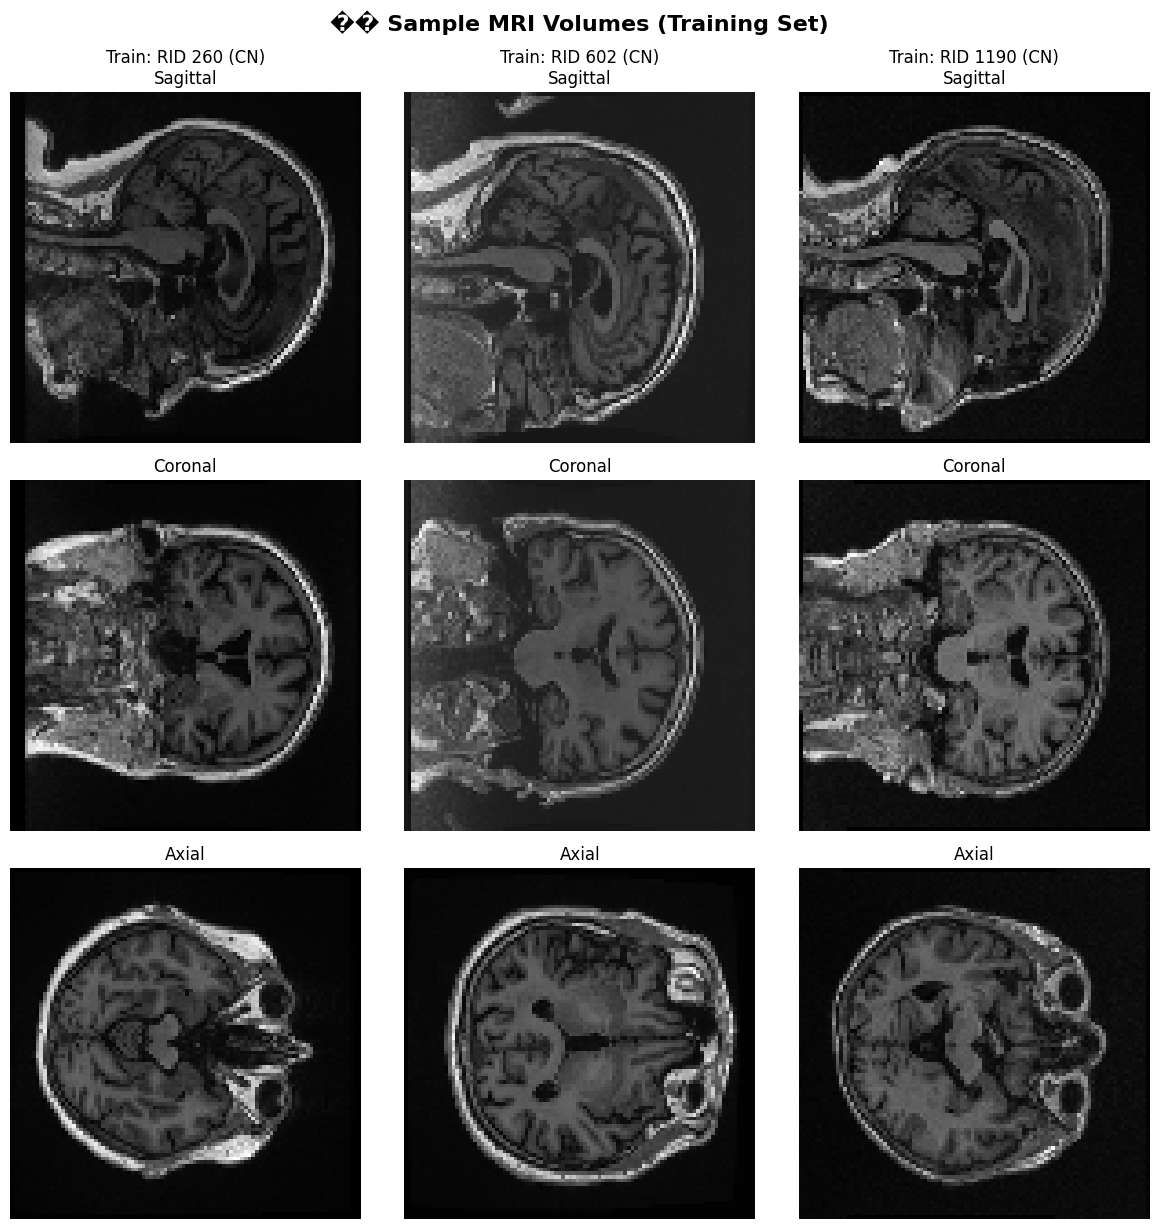


🎯 MRI Data Loading Complete!
�� Final Data Summary:
   • Training samples with MRI: 13
   • Test samples with MRI: 7
   • CV folds available: 5

�� Data Quality Check:
   ✅ Training data available
   ✅ Labels: {'CN'}
   ✅ Test data available
   ✅ Labels: {'AD', 'CN'}

�� Next Steps for CNN Training:
   1. ✅ MRI data loaded and split
   2. 🔄 Implement CNN architectures (ConvNeXt, ResNet, etc.)
   3. 🔄 Data augmentation and preprocessing
   4. 🔄 Training pipeline with CV
   5. 🔄 Performance comparison with protein classifiers

💾 Data Structure Available:
   • mri_splits['train']: Training data
   • mri_splits['test']: Test data
   • mri_splits['cv_folds'][fold]: CV fold data
   • Each split contains: rids, subject_ids, mri_paths, labels

✅ Ready for CNN implementation!


In [7]:

## 5. MRI Data Loading and Preprocessing

def load_mri_volume(mri_path: str, target_shape: Tuple[int, int, int] = (96, 96, 96)) -> np.ndarray:
    """Load and preprocess MRI volume"""
    try:
        # Load NIfTI file
        img = nib.load(mri_path)
        volume = img.get_fdata()
        
        # Basic preprocessing
        # 1. Normalize to [0, 1]
        volume = (volume - volume.min()) / (volume.max() - volume.min())
        
        # 2. Resize to target shape
        if volume.shape != target_shape:
            volume = ndimage.zoom(volume, 
                                [target_shape[0]/volume.shape[0],
                                 target_shape[1]/volume.shape[1],
                                 target_shape[2]/volume.shape[2]])
        
        # 3. Ensure 3D
        if len(volume.shape) == 4:
            volume = volume[:, :, :, 0]  # Take first volume if 4D
        
        return volume.astype(np.float32)
        
    except Exception as e:
        print(f"❌ Error loading {mri_path}: {str(e)}")
        return None

def visualize_mri_samples(mri_splits: Dict, sample_count: int = 3):
    """Visualize sample MRI volumes from each split"""
    
    fig, axes = plt.subplots(3, sample_count, figsize=(4*sample_count, 12))
    
    # Training samples
    if mri_splits['train']['mri_paths']:
        print(f"📊 Visualizing training samples...")
        for i in range(min(sample_count, len(mri_splits['train']['mri_paths']))):
            mri_path = mri_splits['train']['mri_paths'][i]
            rid = mri_splits['train']['rids'][i]
            label = mri_splits['train']['labels'][i]
            
            volume = load_mri_volume(mri_path, target_shape=(96, 96, 96))
            if volume is not None:
                # Show middle slice from each dimension
                mid_x = volume.shape[0] // 2
                mid_y = volume.shape[1] // 2
                mid_z = volume.shape[2] // 2
                
                axes[0, i].imshow(volume[mid_x, :, :], cmap='gray')
                axes[0, i].set_title(f'Train: RID {rid} ({label})\nSagittal')
                axes[0, i].axis('off')
                
                axes[1, i].imshow(volume[:, mid_y, :], cmap='gray')
                axes[1, i].set_title(f'Coronal')
                axes[1, i].axis('off')
                
                axes[2, i].imshow(volume[:, :, mid_z], cmap='gray')
                axes[2, i].set_title(f'Axial')
                axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.suptitle('�� Sample MRI Volumes (Training Set)', fontsize=16, fontweight='bold', y=1.02)
    plt.show()

# Visualize sample MRI data
if any(len(mri_splits[split]['mri_paths']) > 0 for split in ['train', 'test']):
    visualize_mri_samples(mri_splits, sample_count=3)
else:
    print("⚠️ No MRI data found to visualize")

## 6. Data Summary and Next Steps

print(f"\n🎯 MRI Data Loading Complete!")
print("=" * 60)

print(f"�� Final Data Summary:")
print(f"   • Training samples with MRI: {len(mri_splits['train']['rids'])}")
print(f"   • Test samples with MRI: {len(mri_splits['test']['rids'])}")
print(f"   • CV folds available: {len(mri_splits['cv_folds'])}")

print(f"\n�� Data Quality Check:")
if mri_splits['train']['rids']:
    print(f"   ✅ Training data available")
    print(f"   ✅ Labels: {set(mri_splits['train']['labels'])}")
else:
    print(f"   ❌ No training data available")

if mri_splits['test']['rids']:
    print(f"   ✅ Test data available")
    print(f"   ✅ Labels: {set(mri_splits['test']['labels'])}")
else:
    print(f"   ❌ No test data available")

print(f"\n�� Next Steps for CNN Training:")
print(f"   1. ✅ MRI data loaded and split")
print(f"   2. 🔄 Implement CNN architectures (ConvNeXt, ResNet, etc.)")
print(f"   3. 🔄 Data augmentation and preprocessing")
print(f"   4. 🔄 Training pipeline with CV")
print(f"   5. 🔄 Performance comparison with protein classifiers")

print(f"\n💾 Data Structure Available:")
print(f"   • mri_splits['train']: Training data")
print(f"   • mri_splits['test']: Test data")
print(f"   • mri_splits['cv_folds'][fold]: CV fold data")
print(f"   • Each split contains: rids, subject_ids, mri_paths, labels")

print(f"\n" + "=" * 60)
print(f"✅ Ready for CNN implementation!")